In [1]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tiffile import imsave
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
import os

2022-02-24 12:39:14.277532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.5/lib:/usr/local/cuda-11.5/lib64
2022-02-24 12:39:14.277549: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
t2_list = sorted(glob.glob('/media/jainy/project/Depanshu_project/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/media/jainy/project/Depanshu_project/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/media/jainy/project/Depanshu_project/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('/media/jainy/project/Depanshu_project/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [ ]:
for img in range(len(t2_list)):   
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  
    
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
  
    #cropping x, y, and z into size 192*192*128
    temp_combined_images=temp_combined_images[24:216, 24:216, 13:141]
    temp_mask = temp_mask[24:216, 24:216, 13:141]
    
    
    print("Save Me")
    output_filename = 'image_'+str(img)+'.npy'
    temp_mask= to_categorical(temp_mask, num_classes=4)
    np.save('brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels_new/images/image_'+str(img)+'.npy', temp_combined_images)
    np.save('brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels_new/masks/mask_'+str(img)+'.npy', temp_mask)
        
    

In [26]:
import splitfolders  

input_folder = 'brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels_new/'
output_folder = 'brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 738 files [14:52,  1.21s/ files]


In [2]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

      
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)      

            batch_start += batch_size   
            batch_end += batch_size

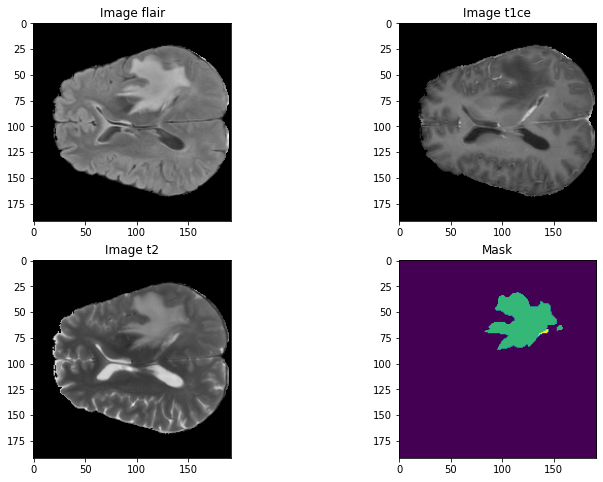

In [10]:



from matplotlib import pyplot as plt
import random

train_img_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/train/images/"
train_mask_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)


img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)
 
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [8]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' 



def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    
    s = inputs

    
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
     
    model.summary()
    
    return model

 
model = simple_unet_model(192, 192, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 192, 192, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 192, 192, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

In [6]:
train_img_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/train/images/"
train_mask_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/train/masks/"

val_img_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/val/images/"
val_mask_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)


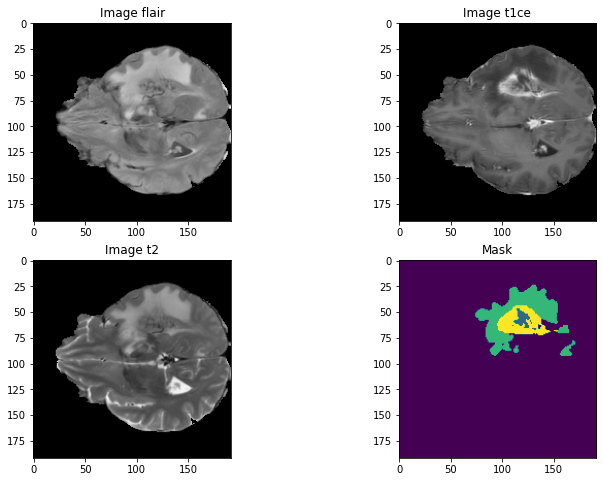

In [8]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [9]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
from tensorflow.keras.optimizers import Adam

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [10]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size




model = simple_unet_model(IMG_HEIGHT=192, 
                          IMG_WIDTH=192, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 192, 192, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 192, 192, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

In [11]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('Seg_BraTS_3d.hdf5')

Epoch 1/5


2022-02-21 19:48:18.884821: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8153726976 exceeds 10% of free system memory.
2022-02-21 19:48:18.884856: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8153726976 exceeds 10% of free system memory.
2022-02-21 19:48:27.021241: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16307453952 exceeds 10% of free system memory.
2022-02-21 19:48:27.021279: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16307453952 exceeds 10% of free system memory.
2022-02-21 19:49:11.529745: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8153726976 exceeds 10% of free system memory.


138/138 [==============================] - 9631s 70s/step - loss: 0.9443 - accuracy: 0.9390 - iou_score: 0.2182 - val_loss: 0.9249 - val_accuracy: 0.9799 - val_iou_score: 0.2437
Epoch 2/5
138/138 [==============================] - 9639s 70s/step - loss: 0.9214 - accuracy: 0.9720 - iou_score: 0.2523 - val_loss: 0.9040 - val_accuracy: 0.9772 - val_iou_score: 0.2986
Epoch 3/5
138/138 [==============================] - 9641s 70s/step - loss: 0.9033 - accuracy: 0.9692 - iou_score: 0.3356 - val_loss: 0.8945 - val_accuracy: 0.9696 - val_iou_score: 0.3779
Epoch 4/5
138/138 [==============================] - 9642s 70s/step - loss: 0.8865 - accuracy: 0.9755 - iou_score: 0.4060 - val_loss: 0.8783 - val_accuracy: 0.9771 - val_iou_score: 0.4330
Epoch 5/5
138/138 [==============================] - 9651s 70s/step - loss: 0.8729 - accuracy: 0.9793 - iou_score: 0.4472 - val_loss: 0.8940 - val_accuracy: 0.9484 - val_iou_score: 0.3847


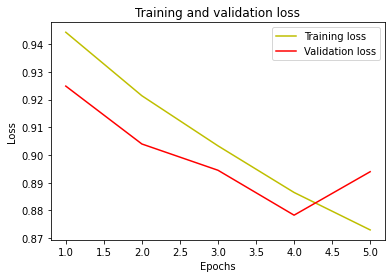

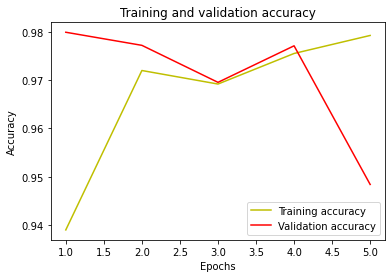

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#############################################
#Predict on a few test images, one at a time
#Try images: 
img_num = 83

test_img = np.load("brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))





Mean IoU = 0.40781343


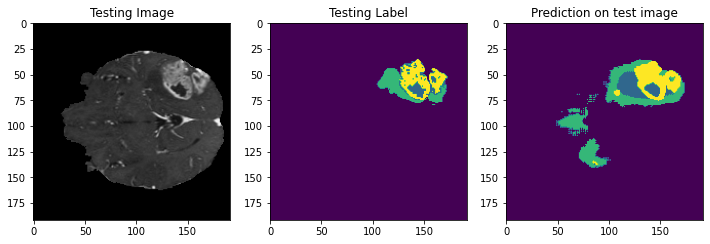

In [37]:
#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 50
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()
